# Introdução

Análise (expansão da análise) de um grafo de rede social de um dataset público com base no livro/Github citado nas referências.


**Análise de grafos em redes sociais**

Estudo de aplicação utilizado na apresentação para os membros do LAMFO realizada em 09/04/2022: Introdução a grafos e análise de redes sociais.

* Análise de métricas;
* Identificação de nós relevantes;
* Identificação de comunidades;
* Uso de node embeddings para predição de links (uso de muitas funções do autor sem modificação + expansão da análise).

# Dataset

Fonte:

J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.

[SNAP Facebook Social Graph](https://snap.stanford.edu/data/ego-Facebook.html)

O dataset foi crido com a coleta de informações em uma pesquisa com participantes via aplicativo do Facebook. Os conjuntos de dados de ego-networks, quando combinados, gera a rede agregada a partir da lista de amigos do Facebook de dez indivíduos. Nesse conjunto de dados, os vértices representam indivíduos no Facebook e uma aresta entre dois usuários significa que eles são amigos. Cada ego-network consiste de um usuário do Facebook e seus amigos. As ego-networks são então agregadas identificando indivíduos que aparecem em múltiplas ego-networks, formando um único grafo.

Em média cada usuário identificou 19 círculos (lista de amigos) nos quais seus amigos estão presentes, com uma média de 22 amigos em cada.

Node features: anônimas para não revelar informação pessoal. Features rotuladas como 1 se o usuário tem determinada propriedade e como 0 caso não a possua.  


In [1]:
# Download
# Arquivo texto contendo a lista de arestas de todas ego-networks combinadas (todas arestas)
!wget http://snap.stanford.edu/data/facebook_combined.txt.gz
# Pasta contendo informações relacionadas a cada ego-network
!wget http://snap.stanford.edu/data/facebook.tar.gz
!gzip -d facebook_combined.txt.gz
!tar -xf facebook.tar.gz

--2022-04-18 14:15:13--  http://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   619KB/s    in 0.3s    

2022-04-18 14:15:13 (619 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]

--2022-04-18 14:15:13--  http://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K  1.10MB/s    in 0.6s    

2022-04-18 14:15:14 (1.10 MB/s) - ‘facebook.tar.gz’ saved [73

## Overview

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

Criação do grafo da rede combinada e obtenção do nodeId de cada ego-user a partir dos nomes dos arquivos.

In [3]:
edges = pd.read_csv('/content/facebook_combined.txt', sep=' ', names=['node1', 'node2'])  # A ser usado mais à frente
# G = nx.from_pandas_edgelist(edges, *edges.columns, create_using=nx.DiGraph()) # Alternativa

In [4]:
edges

,node1,node2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
88229,4026,4030
88230,4027,4031
88231,4027,4032
88232,4027,4038


In [5]:
# Tamanho do grafo (size)
print(f'Tamanho do grafo: {len(edges)}')

Tamanho do grafo: 88234


In [6]:
# print(f'Número de nós {G.number_of_nodes()}\n')
# print(f'Número de arestas {G.number_of_edges()}\n')

In [7]:
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

In [8]:
# Informações gerais
print(nx.info(G))

Graph with 4039 nodes and 88234 edges


In [9]:
import os

# Ego nodes
ego_nodes = set([int(name.split('.')[0]) for name in os.listdir("facebook/")])
ego_nodes

{0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980}

Visualização da rede.

In [10]:
import matplotlib.pyplot as plt

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Criação da rede para visualização

pos_fr = nx.spring_layout(G)  # Posicionamento usando algoritmo de Fruchterman-Reingold (nx.fruchterman_reingold_layout(G))
#pos_kk = nx.kamada_kawai_layout(G)  # Comparação com algoritmo Kamada-Kawai

In [16]:
# Tamanho das figuras
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)  # Padrão ~(6, 4)

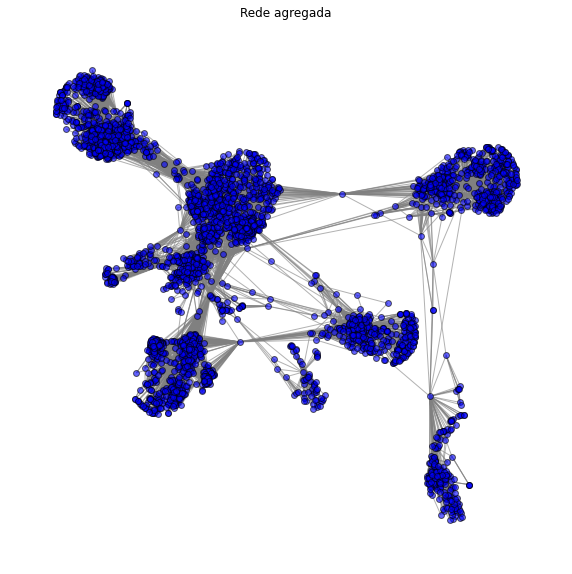

In [20]:
plt.figure()
plt.axis("off")
plt.title('Rede agregada')
nx.draw_networkx(G, pos=pos_fr, node_size=35, node_color='blue', edge_color='gray', alpha=0.6, with_labels=False, edgecolors='black')

In [21]:
# Diferentes layouts

# plt.figure(figsize=(20, 10))
# plt.axis("off")
# plt.subplot(1,2,1)
# plt.title('Layout Fruchterman-Reingold')
# nx.draw_networkx(G, pos=pos_fr, node_color='blue', edge_color='gray', alpha=0.4, with_labels=False, node_size=5)
# plt.subplot(1,2,2)
# plt.title('Layout Kamada-Kawai')
# nx.draw_networkx(G, pos=pos_kk, node_color='blue', edge_color='gray', alpha=0.4, with_labels=False, node_size=5)

# Análise

## Métricas

A Centralidade de Intermediação (Betweenness) mede quantos shortest paths passam por um dado nó, dando a ideia do quão central o nó é para o espalhamento da informação dentro da rede. Indica a presença de nós que têm alta influência na comunicação entre regiões distantes do grafo, formando pontes. O valor médio 
obtido é bem baixo, o que é compreensível dada a grande quantidade de nós que não formam pontes entre hubs dentro da rede. A inspeção visual no grafo permite obter maiores insights (a seguir).

In [22]:
# Betweenness Centrality (centralidade de intermediação)
bet_cent = nx.betweenness_centrality(G)
# Média
np.mean(list(bet_cent.values()))

0.0006669573568730229

A Centralidade de Grau (Degree) está relacionada ao número de vizinhos de um nó, dando a ideia do quão conectados os nós estão entre si.

In [23]:
# Degree Centrality (Centralidade de Grau)
deg_cent = nx.degree_centrality(G)
# Média
np.mean(list(deg_cent.values()))

0.010819963503439287

In [25]:
# Nós com maior centralidade de grau
deg_cent_items = deg_cent.items()
deg_cent_items_sorted = sorted(deg_cent_items, key = lambda item:item[1], reverse = True)
deg_cent_sorted = {k:v for k, v in deg_cent_items_sorted}
important_nodes = list(deg_cent_sorted)[:2]
important_nodes

[107, 1684]

A Centralidade de Proximidade (Closeness) ajuda a entender quão perto os nós estão um dos outros em termos de shortest paths. Um nó com uma alta Centralidade de Proximidade tipicamente tem muitos caminhos mais curtos para chegar a todos os outros nós dentro do grafo.

In [26]:
# Closeness Centrality (Centralidade de Proximidade)
closeness_cent = nx.closeness_centrality(G)
# Média
np.mean(list(closeness_cent.values()))

0.2761677635668376

A Centralide de Autovetor (Eigenvector) de um dado nó está relacionada à conectividade dos vizinhos próximos. Um dado nó pode não ser importante por si, mas ele pode se relacionar a outros nós com alta conectividade, o que pode indicar alto nível de influência.

In [27]:
# Eigenvector Centrality (Centralidade de Autovetor)
eigen_cent = nx.eigenvector_centrality(G)
# Média
np.mean(list(eigen_cent.values()))

0.003864340807927154

Visualização.

In [31]:
# Gera o grafo para a métrica de centralidade com os 10 nós de maior valor realçados
def draw_centrality_metric(G, metric, pos):

    # Obtem os 10 nós cujos valores da métrica são mais elevados
    #max_nodes =  sorted(metric.items(), key = lambda v: -v[1])[:10]
    nodes_sorted = sorted(metric.items(), key = lambda item:item[1], reverse = True)[:10]

    nodes_sorted_keys = [key for key,_ in nodes_sorted]
    nodes_sorted_values = [val*1000 for _, val in nodes_sorted]

    plt.axis("off")
    nx.draw_networkx(G, pos=pos, edge_color='gray', node_color='blue', node_size=35, alpha=0.6, with_labels=False, edgecolors='black')
    
    # Realça os 10 nós cujos valores da métrica são mais elevados 
    nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes_sorted_keys, node_color='orange', node_size=nodes_sorted_values, alpha=0.8)
    nodes.set_edgecolor('black')

    return nodes_sorted_keys # Retorna os valores para futura comparação entre as métricas de centralidade

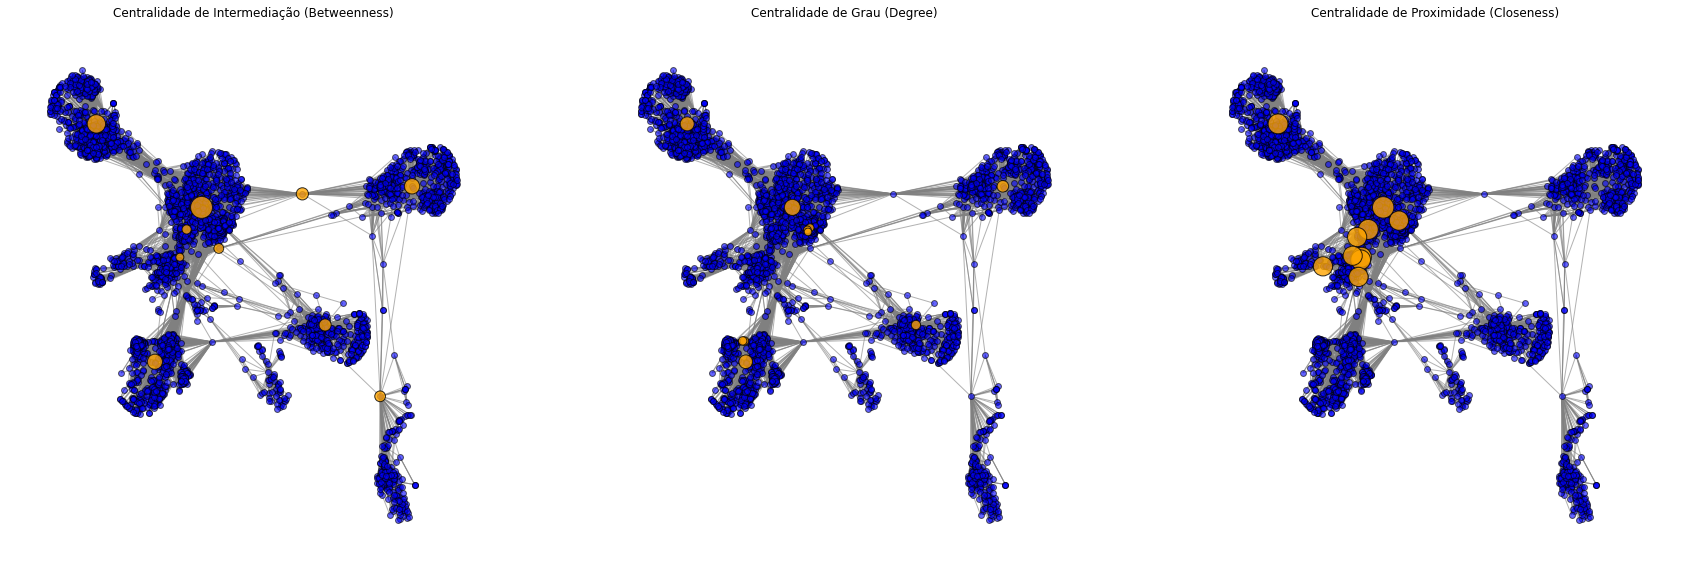

In [32]:
plt.figure(figsize=(30, 10))
plt.axis("off")
plt.subplot(1,3,1)
plt.title('Centralidade de Intermediação (Betweenness)')
bet_cent_list = draw_centrality_metric(G, bet_cent, pos_fr)
plt.subplot(1,3,2)
plt.title('Centralidade de Grau (Degree)')
deg_cent_list = draw_centrality_metric(G, deg_cent, pos_fr)
plt.subplot(1,3,3)
plt.title('Centralidade de Proximidade (Closeness)')
closeness_cent_list = draw_centrality_metric(G, closeness_cent, pos_fr)

# plt.figure(figsize=(20, 20))
# plt.axis("off")
# plt.subplot(2,2,1)
# plt.title('Centralidade de Intermediação (Betweenness)')
# bet_cent_list = draw_centrality_metric(G, bet_cent, pos_fr)
# plt.subplot(2,2,2)
# plt.title('Centralidade de Grau (Degree)')
# deg_cent_list = draw_centrality_metric(G, deg_cent, pos_fr)
# plt.subplot(2,2,3)
# plt.title('Centralidade de Proximidade (Closeness)')
# closeness_cent_list = draw_centrality_metric(G, closeness_cent, pos_fr)
# plt.subplot(2,2,4)
# plt.title('Centralidade de Autovetor (Eigenvector)')
# eigen_cent_list = draw_centrality_metric(G, eigen_cent, pos_fr)

In [33]:
# Nós com maiores valores para métricas de centralidade
dicio = {'centralidade_intermediacao': bet_cent_list, 
        'centralidade_grau': deg_cent_list, 
        'centralidade_proximidade': closeness_cent_list}
metricas = pd.DataFrame(dicio)
metricas

,centralidade_intermediacao,centralidade_grau,centralidade_proximidade
0,107,107,107
1,1684,1684,58
2,3437,1912,428
3,1912,3437,563
4,1085,0,1684
5,0,2543,171
6,698,2347,348
7,567,1888,483
8,58,1800,414
9,428,1663,376


Os nós 107 e 1684 aparecem em todas as colunas com alto valor em termos de métricas de centralidade (influencers?). De fato é até esperado uma vez que são ego nodes na nossa rede.

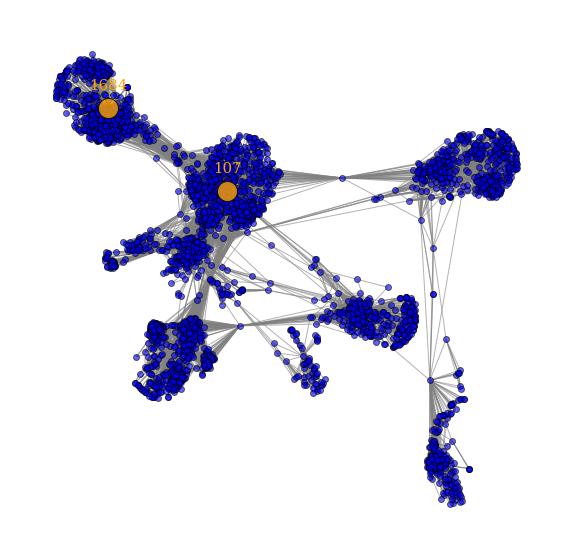

In [34]:
# 107, 1684
plt.axis("off")
nx.draw_networkx(G, pos=pos_fr, edge_color='gray', node_color='blue', node_size=35, alpha=0.6, with_labels=False, edgecolors='black')

nodelist = metricas.loc[:1, 'centralidade_grau'].values.tolist()

# Realça os 2 nós cujos valores de métrica de centralidade são mais elevados 
nodes_metr = nx.draw_networkx_nodes(G, pos=pos_fr, nodelist=nodelist, node_color='orange', node_size=400, alpha=0.8)
nodes_metr.set_edgecolor('black')

pos_attrs = {}
for node, coords in pos_fr.items():
    if node in nodelist:
        pos_attrs[node] = (coords[0], coords[1] + 0.08)

# Labels
_ = nx.draw_networkx_labels(G, pos=pos_attrs, labels={node:node for node in nodelist}, font_family='serif', font_color='orange', font_size=15)

**Algumas outras métricas:**

A Eficiência global é a média do inverso do comprimento dos caminhos mais curtos para todos os pares de nós e pode ser entendida como uma medida da eficiência na troca de informações. A Eficiência é máxima quando o grafo é totalmente conectado

In [35]:
# Global Efficiency
global_efficiency = nx.global_efficiency(G)
print(global_efficiency)

0.30657814798734856


A assortatividade revela informação sobre a tendência de usuários se conectarem com usuários com grau semelhante. Obtivemos uma assortatividade positiva, que mostra que usuários bem conectados se associam com outros usuários bem conectados.

In [36]:
# Assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

0.06357722918564912

A transitividade também ajuda a entender como indivíduos são conectados. Ela indica a probabilidade de duas pessoas com um amigo em comum serem amigos entre si. O resultado obtido indica um probabilidade de aproximadamente 50% de que dois amigos possam ter ou não amigos em comum.

In [37]:
transitivity = nx.transitivity(G)
transitivity

0.5191742775433075

O coeficiente de agrupamento (clustering) fornece uma medida do grau em que os nós tendem a se agrupar. Em redes sociais, particularmente, os nós tendem a criar grupos fortemente unidos caracterizados por uma densidade relativamente alta de laços.

In [38]:
# Average Clustering
average_clustering = nx.average_clustering(G)
print(average_clustering)

0.6055467186200876


## Power-law

Muitos grafos apresentam em sua estrutura uma distribuição de grau que segue uma lei de potência (Power-law), que mostra que existem poucos vértices de grau elevado, enquanto muitos vértices apresentam grau baixo.

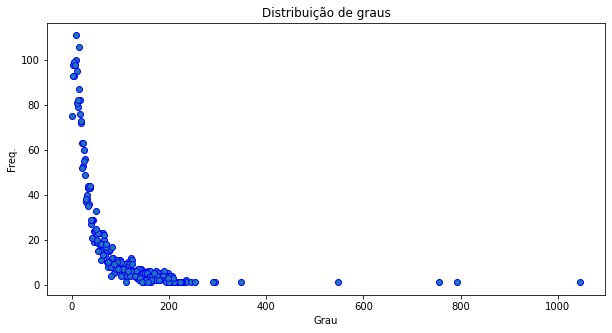

In [39]:
from collections import Counter

lista_graus = [G.degree(n) for n in G.nodes()]
degrees_counter = Counter(lista_graus)
graus, frequencia_graus = zip(*degrees_counter.items())

plt.figure(figsize=(10,5))
plt.scatter(graus, frequencia_graus, edgecolors='blue')
plt.title('Distribuição de graus')
plt.xlabel('Grau')
plt.ylabel('Freq.')
plt.show()

## Detecção de comunidades

Detecção de comunidades  usando informações da topologia da rede.

In [40]:
!pip install python-louvain

In [41]:
from community import community_louvain
#from networkx.algorithms import community  # Erro

#parts = community.louvain_communities(G) # Erro
parts = community_louvain.best_partition(G) # Algoritmo de detecção de comunidades de Louvain

values = [parts.get(node) for node in G.nodes()]

for node in ego_nodes:
    print(f'O nó {node} está presente na comunidade {parts.get(node)}')

O nó 0 está presente na comunidade 0
O nó 107 está presente na comunidade 3
O nó 3980 está presente na comunidade 14
O nó 3437 está presente na comunidade 10
O nó 686 está presente na comunidade 15
O nó 1684 está presente na comunidade 5
O nó 1912 está presente na comunidade 4
O nó 698 está presente na comunidade 15
O nó 348 está presente na comunidade 1
O nó 414 está presente na comunidade 1


In [42]:
# Comunidades detectadas
len(list(set(values)))

16

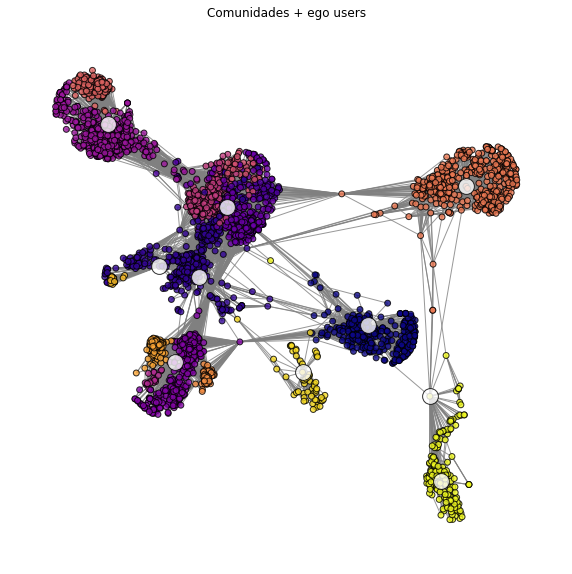

In [43]:
plt.axis("off")
plt.title('Comunidades + ego users')
nx.draw_networkx(G, pos=pos_fr, cmap=plt.get_cmap("plasma"), edge_color='gray', node_color=values, node_size=35, alpha=0.8, with_labels=False, edgecolors='black')

# Realce de cor e tamanho de ego-nodes
#nodes = nx.draw_networkx_nodes(G, pos_fr, ego_nodes, node_size=250, node_color=[parts.get(node) for node in ego_nodes], alpha=0.8)
nodes = nx.draw_networkx_nodes(G, pos_fr, nodelist=ego_nodes, node_size=250, node_color='white', alpha=0.8)
nodes.set_edgecolor('black')

Alguns ego users pertencem a uma mesma comunidade. É possível que ego users sejam de fato amigos no Facebook e que suas redes ego sejam parcialmente conectadas.

As comunidades se alinham com os hubs. Como esse conjunto de dados foi compilado agregando a rede ego de dez indivíduos, as diferentes comunidades provavelmente refletem as diferentes redes ego.

#### Análise de ego network

Análise da subrede do usuário ego 107.

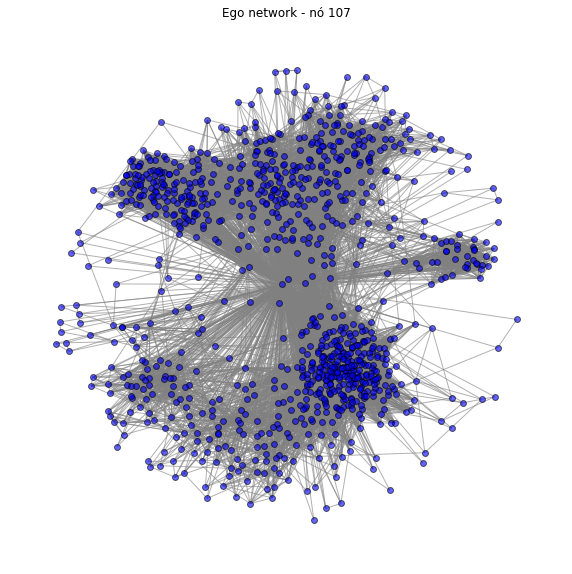

In [44]:
G107 = nx.read_edgelist("facebook/107.edges", create_using=nx.Graph(), nodetype=int)
for node in G107.copy():
    G107.add_edge(107,node)

plt.axis("off")
plt.title('Ego network - nó 107')
pos_G107 = nx.spring_layout(G107)
nx.draw_networkx(G107, pos=pos_G107, edge_color='gray', node_color='blue', node_size=35, alpha=0.6, with_labels=False, edgecolors='black')

In [45]:
# Círculos (listas de amigos)
circles = {}

with open("facebook/107.circles") as f_in:
    line = f_in.readline().rstrip().split("\t")
    while line and not '' in line:
        circles[line[0]] = [int(v) for v in line[1:]]
        line = f_in.readline().rstrip().split("\t")

9 círculos.



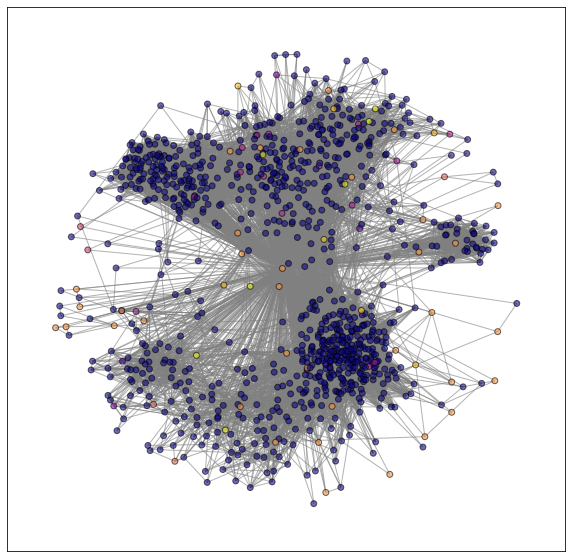

In [46]:
# Visualização de círculos de amizade
node_colors = [0] * G107.number_of_nodes()
count = 0
for key in circles:
    circle = circles[key]
    for node in circle:
        if node < G107.number_of_nodes():
            node_colors[node] = count
    count += 1

print(f'{count} círculos.\n')
nx.draw_networkx(G107, pos=pos_G107, cmap=plt.get_cmap("plasma"), edge_color='gray', node_color=node_colors, node_size=35, alpha=0.6, with_labels=False, edgecolors='black')

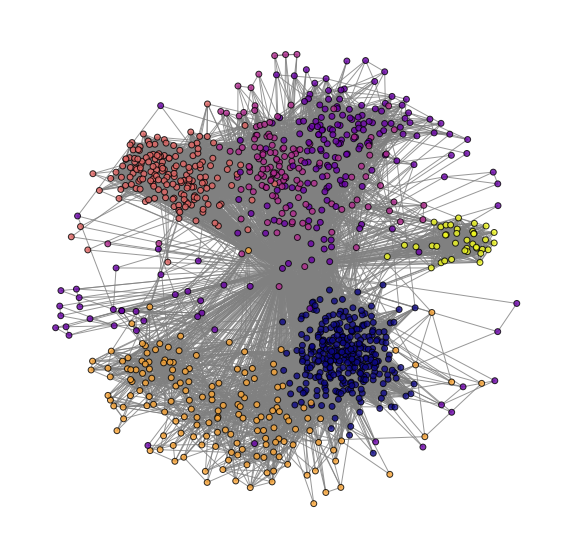

In [48]:
# Detecção de comunidades
parts = community_louvain.best_partition(G107)
values = [parts.get(node) for node in G107.nodes()]

plt.axis("off")
nx.draw_networkx(G107, pos=pos_G107, cmap=plt.get_cmap("plasma"), edge_color='gray', node_color=values, node_size=35, alpha=0.8, with_labels=False, edgecolors='black')

In [49]:
# Comunidades
len(list(set(values)))

6

In [50]:
# Dataframe contendo o nó e a comunidade a qual ele pertence
df_no_comunidade = pd.DataFrame(list(parts.items()), columns=['no', 'comunidade'])
df_no_comunidade

,no,comunidade
0,953,0
1,1323,0
2,1789,0
3,1707,0
4,1175,0
...,...,...
1030,1690,1
1031,1262,1
1032,1558,4
1033,1430,2


In [51]:
# Número de nós por comunidade
df_no_comunidade['comunidade'].value_counts()

0    318
1    207
3    169
4    164
2    139
5     38
Name: comunidade, dtype: int64

## Embeddings

**Taxonomia de Graph Embedding Learning**

[Machine Learning on Graphs: A Model and Comprehensive Taxonomy](https://arxiv.org/abs/2005.03675)

Os métodos de Graph Representation Learning (GRL) visam aprender representações vetoriais contínuas de baixa dimensão para dados estruturados em grafos, também chamados de embeddings. De modo geral, GRL pode ser dividido em duas classes, GRL não supervisionado e supervisionado (ou ainda outra, semi-supervisionado). A primeira família visa aprender representações euclidianas de baixa dimensão que preservam a estrutura de um grafo de entrada. A segunda família também aprende representações euclidianas de baixa dimensão, mas para uma tarefa específica de previsão, como classificação de nó ou de grafo. Diferentemente da configuração não supervisionada, em que as entradas geralmente são estruturas gráficas, as entradas em configurações supervisionadas geralmente são compostas por features de nós (Chami et al. 2022).


**Aprendizado não supervisionado com grafos**

* Shallow Embedding
  * Matrix Factorization
    * HOPE
    * GraphRep
    * Graph Factorization
  * Skip-gram
    * **Node2Vec** (extensão do DeepWalk)
    * Edge2Vec
    * Graph2Vec
* Autoencoders
  * SDNE
* GNN
  * Spectral (GCN)
  * Spatial (eg. GraphSAGE)

**Aprendizado supervisionado com grafos**
* Feature-based
* Shallow Embedding
  * Label Propagation
  * Label Spreading
* Regularization
  * Manifold and semi-embedding
  * Neural Graph Learning
* GNN
  * Spectral (GCN)
  * Spatial (eg. **GraphSAGE**)

Obs: GraphSAGE é em geral usado de forma supervisionada, mas também pode ser usado de forma não-supervisionada.




**Predição de links**

Grande parte das funções, principalmente para obtenção de features e criação de novas, foram aproveitadas de forma literal.

#### Parse node features

Carrega todas features de cada nó (Github do livro) 

In [52]:
# Adapted from https://github.com/jcatw/snap-facebook

feat_file_name = "feature_map.txt"
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()

def parse_featname_line(line):
  """ used to parse each line of the files containing feature names """
  line = line[(line.find(' '))+1:]  # chop first field
  split = line.split(';')
  name = ';'.join(split[:-1]) # feature name
  index = int(split[-1].split(" ")[-1]) #feature index
  return index, name

def load_features():
  """ 
  parse each ego-network and creates two dictionaries:
      - feature_index: maps numeric indices to names
      - inverted_feature_index: maps names to numeric indices
  """
  import glob
  feat_file_name = 'tmp.txt'
  # may need to build the index first
  if not os.path.exists(feat_file_name):
      feat_index = {}
      # build the index from data/*.featnames files
      featname_files = glob.iglob("facebook/*.featnames")
      for featname_file_name in featname_files:
          featname_file = open(featname_file_name, 'r')
          for line in featname_file:
              # example line:
              # 0 birthday;anonymized feature 376
              index, name = parse_featname_line(line)
              feat_index[index] = name
          featname_file.close()
      keys = feat_index.keys()
      keys = sorted(keys)
      out = open(feat_file_name,'w')
      for key in keys:
          out.write("%d %s\n" % (key, feat_index[key]))
      out.close()

  index_file = open(feat_file_name,'r')
  for line in index_file:
      split = line.strip().split(' ')
      key = int(split[0])
      val = split[1]
      feature_index[key] = val
  index_file.close()

  for key in feature_index.keys():
      val = feature_index[key]
      inverted_feature_index[val] = key

def parse_nodes(network, ego_nodes):
  """
  for each nodes in the network assign the corresponding features 
  previously loaded using the load_features function
  """
  # parse each node
  for node_id in ego_nodes:
      featname_file = open(f'facebook/{node_id}.featnames','r')
      feat_file     = open(f'facebook/{node_id}.feat','r')
      egofeat_file  = open(f'facebook/{node_id}.egofeat','r')
      edge_file     = open(f'facebook/{node_id}.edges','r')

      ego_features = [int(x) for x in egofeat_file.readline().split(' ')]

      # Add ego node features
      network.nodes[node_id]['features'] = np.zeros(len(feature_index))
      
      # parse ego node
      i = 0
      for line in featname_file:
          key, val = parse_featname_line(line)
          # Update feature value if necessary
          if ego_features[i] + 1 > network.nodes[node_id]['features'][key]:
              network.nodes[node_id]['features'][key] = ego_features[i] + 1
          i += 1

      # parse neighboring nodes
      for line in feat_file:
          featname_file.seek(0)
          split = [int(x) for x in line.split(' ')]
          node_id = split[0]
          features = split[1:]

          # Add node features
          network.nodes[node_id]['features'] = np.zeros(len(feature_index))

          i = 0
          for line in featname_file:
              key, val = parse_featname_line(line)
              # Update feature value if necessary
              if features[i] + 1 > network.nodes[node_id]['features'][key]:
                  network.nodes[node_id]['features'][key] = features[i] + 1
              i += 1
          
      featname_file.close()
      feat_file.close()
      egofeat_file.close()
      edge_file.close()

In [53]:
# Parse edge features and add them to the networkx nodes
load_features()
parse_nodes(G, ego_nodes)

#### Predição de links (link prediction)

Permite a previsão da probabilidade de uma futura conexão entre nós.

Tratamos o problema com aprendizado supervisionado. Pares de nós são entradas para o algoritmo e a saída é binária: conectada se dois nós são de fato conectados na rede e não conectada, caso contrário.

- Método 1: Node2Vec para obtenção de embeddings dos nós de forma não supervisionada, a serem usados como entrada em um algoritmo de classificação supervisionado (Random Forest) para determinar se o par de nós de entrada é conectado.
- Método 2: Uso de um algoritmo baseado em GNN (GraphSAGE com e sem features reais) de forma a conjuntamente aprender embeddings e realizar a tarefa de classificação.
- Método 3: uso de handcrafted features a serem usadas como entrada em um algoritmo de classificação supervisionado, juntamente com ids dos nós.

In [55]:
!pip install stellargraph
!pip install node2vec==0.3.3

     |████████████████████████████████| 435 kB 5.5 MB/s 
     |████████████████████████████████| 462 kB 36.3 MB/s 
  Created wheel for node2vec: filename=node2vec-0.3.3-py3-none-any.whl size=5673 sha256=2ef782fd168e44c30a0ad386abd58d8a53e61d5532a7e2c5fe2c328fc1ed70f4
  Stored in directory: /root/.cache/pip/wheels/da/ba/7d/e3e173c4133d8b8c498981bdd8b115e4bd5dcf6c314e513fa6
Successfully built node2vec


Usamos a biblioteca Stellargraph para criação dos conjuntos de treinamento e teste. Criam-se dois subgrafos.

In [56]:
# Criação dos conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G) 
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

** Sampled 8823 positive and 8823 negative edges. **
** Sampled 7941 positive and 7941 negative edges. **


##### Node2Vec

O Node2Vec é usado para gerar embeddings dos nós de modo não-supervisionado a partir do grafo de treinamento. Usou-se então outro algoritmo (HadamardEmbedder) para gerar embeddings para cada par de nós codificados, que são usados como entrada para o classificador.

Usamos um classificador Random Forest e aplicamos o modelo treinado para criar embeddings para o conjunto de teste e então realizamos a predição no conjunto de testes. 


In [57]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 

node2vec = Node2Vec(graph_train)
model = node2vec.fit()
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

Generating walks (CPU: 1): 100%|██████████| 10/10 [03:54<00:00, 23.41s/it]


In [58]:
# Embeddings no dataframe para verificar o uso de KMeans
node_list = edges.iloc[:, 0].unique()
node_str = []
for n in node_list:
    node_str.append(str(n))

In [59]:
df_embeddings = pd.DataFrame()
for i in node_str:
    t1 = pd.DataFrame(model.wv.get_vector(i)).T
    df_embeddings = df_embeddings.append(t1)
    df_embeddings = df_embeddings.reset_index(drop=True)

In [60]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,2.944794,-0.061701,0.548003,-1.774518,0.381828,-1.354541,1.131689,-1.232690,1.406336,1.024049,...,0.775511,-1.017508,0.976423,-0.164785,1.020920,-0.369578,0.914064,0.517130,2.845220,-0.875931
1,1.180872,0.964042,-0.035136,-0.388043,0.351869,-1.158899,0.344304,-0.359494,-1.169178,0.223860,...,1.039641,0.370738,1.286607,-0.645485,1.342914,-0.220492,-0.590381,0.665298,0.624159,-1.761978
2,0.537546,-0.394478,-0.207680,0.133411,0.354902,0.149308,-0.630809,-0.076884,-0.019728,-0.083110,...,-0.125781,0.026443,-0.441339,-0.031040,0.525323,0.506907,-0.113989,-0.161661,1.259741,-0.164885
3,0.999964,0.267302,0.469957,0.439854,0.520539,-0.588186,0.104471,0.198512,-0.407330,-0.533794,...,0.989413,-0.191710,0.036760,-0.853778,-0.166483,-0.290949,0.352879,-0.272892,1.218956,-0.957780
4,-0.416006,0.270476,-0.606601,-1.075807,-0.670379,-0.136192,0.107651,-0.346036,1.450478,0.347948,...,0.024752,0.549610,0.536755,-0.519468,0.484715,0.439191,1.098860,0.692473,0.634262,-1.223014


In [61]:
# Clustering
from sklearn.cluster import KMeans
num_clusters = 10 # Há melhores formas de se estabelecer

kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(df_embeddings)
labels = kmeans.predict(df_embeddings)
df_embeddings['cluster'] = labels

In [63]:
#df_embeddings.head()

In [64]:
# Redução de dimensionalidade
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

componentes_principais = pca.fit_transform(df_embeddings)
df_principal = pd.DataFrame(data = componentes_principais, columns=['pca1', 'pca2'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [65]:
df_principal['cluster'] = df_embeddings['cluster']

In [66]:
df_principal['cluster'].value_counts()

3    594
1    493
0    462
5    437
2    431
4    328
8    276
9    264
6    209
7    169
Name: cluster, dtype: int64

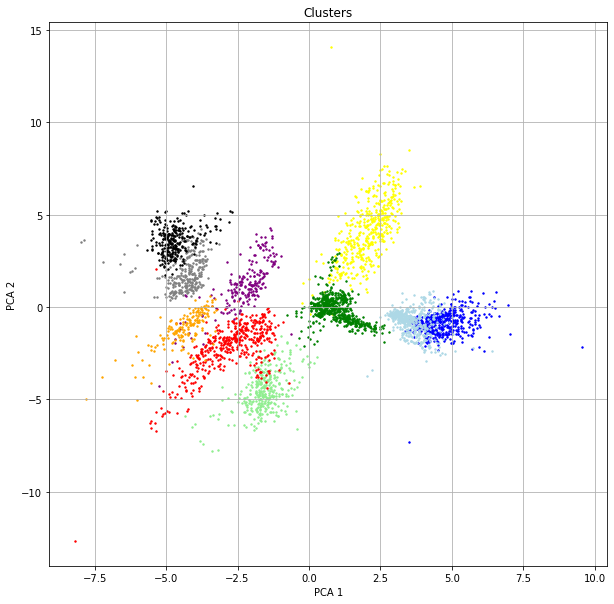

In [67]:
plt.figure()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters')
cluster = np.arange(10)
color = ['blue', 'lightblue', 'yellow', 'green', 'lightgreen', 'red', 'purple', 'orange', 'gray', 'black']
for cluster, color in zip(cluster, color):
    indicestokeep = df_principal['cluster']==cluster
    plt.scatter(df_principal.loc[indicestokeep, 'pca1'],
                df_principal.loc[indicestokeep, 'pca2'],
                c=color,
                s=2)
plt.grid()

Verificou-se o uso de KMeans, que corrobora com a presença de comunidades detectadas no grafo (aqui com 10 clusters).

Resultados do classificador + GridSearch com cross validation.

In [68]:
from pandas.core.common import random_state
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=10, random_state=101)
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8823
           1       0.97      0.97      0.97      8823

    accuracy                           0.97     17646
   macro avg       0.97      0.97      0.97     17646
weighted avg       0.97      0.97      0.97     17646



In [69]:
# GridSearch com cross Validation (5 folds)
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [5, 10, None]
}

clf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
clf.fit(train_embeddings, labels_train)
print(clf.best_params_)

{'max_depth': None, 'n_estimators': 200}


In [70]:
# Melhor estimador (não muda muita coisa)
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=101)
rfc.fit(train_embeddings, labels_train);
y_pred = rfc.predict(test_embeddings)
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8823
           1       0.97      0.98      0.97      8823

    accuracy                           0.97     17646
   macro avg       0.97      0.97      0.97     17646
weighted avg       0.97      0.97      0.97     17646



##### GraphSAGE

O GraphSAGE precisa de features, que podem ou não estar disponíveis em seu conjunto de dados.

###### GraphSAGE sem features

Inicialmente não consideramos as features dos nós. Aqui usou-se uma abordagem de atribuir a cada nó um vetor codificado (one-hot encoded) de comprimento igual ao número de nós do grafo, onde apenas a célula correspondente ao nó fornecido é 1, enquanto as células restantes são 0.

In [71]:
eye = np.eye(graph_train.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_train, fake_features, "fake")

eye = np.eye(graph_test.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_test, fake_features, "fake")

In [72]:
graph_train.nodes[0]

{'fake': array([1., 0., 0., ..., 0., 0., 0.]),
 'features': array([1., 1., 1., ..., 0., 0., 0.])}

In [73]:
from stellargraph.mapper import GraphSAGELinkGenerator

# Tamanho do batch a ser enviado à GPU
batch_size = 64
num_samples = [4, 4]

# Para obter feature vectors de um atributo do nó em um grafo NetworkX, onde graph_train/graph_test contém nós
# que têm um atributo "fake" contendo o vetor de features para o nó.
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

Modelo GraphSAGE com duas camadas ocultas de tamanho 20, cada uma com um termo de polarização e uma camada de dropout para reduzir overfitting (regularização). Em seguida, a saída é concatenada com uma camada de classificação, que recebe pares de embeddings de nós (saída do GraphSAGE), usa operadores binários (produto interno nesso caso para a operação de convolução) para produzir embeddings de borda e para finalmente passar pelo head de classificação fully-connected.

* Learning rate: 1e-3

* Epochs: 10

In [74]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)  # produto interno

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [75]:
epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/10
249/249 [==============================] - 57s 207ms/step - loss: 0.2329 - acc: 0.6012 - val_loss: 0.1924 - val_acc: 0.7253
Epoch 2/10
249/249 [==============================] - 36s 145ms/step - loss: 0.1936 - acc: 0.7323 - val_loss: 0.1825 - val_acc: 0.7422
Epoch 3/10
249/249 [==============================] - 36s 146ms/step - loss: 0.1838 - acc: 0.7543 - val_loss: 0.1785 - val_acc: 0.7507
Epoch 4/10
249/249 [==============================] - 37s 147ms/step - loss: 0.1787 - acc: 0.7629 - val_loss: 0.1748 - val_acc: 0.7632
Epoch 5/10
249/249 [==============================] - 37s 150ms/step - loss: 0.1753 - acc: 0.7802 - val_loss: 0.1727 - val_acc: 0.7838
Epoch 6/10
249/249 [==============================] - 37s 149ms/step - loss: 0.1721 - acc: 0.7954 - val_loss: 0.1713 - val_acc: 0.7981
Epoch 7/10
249/249 [==============================] - 37s 149ms/step - loss: 0.1701 - acc: 0.8059 - val_loss: 0.1720 - val_acc: 0.7989
Epoch 8/10
249/249 [==============================] - 3

Curvas de loss de treinamento e validação.

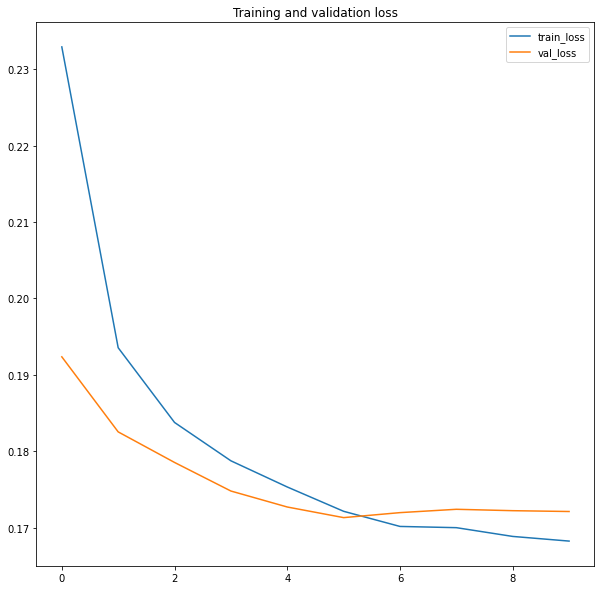

In [76]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.title('Training and validation loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

Resultados:

In [77]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print(classification_report(labels_train, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.33      0.40      7941
           1       0.50      0.68      0.58      7941

    accuracy                           0.50     15882
   macro avg       0.51      0.50      0.49     15882
weighted avg       0.51      0.50      0.49     15882



In [78]:
y_pred = np.round(model.predict(test_flow)).flatten()
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      8823
           1       0.72      0.99      0.83      8823

    accuracy                           0.80     17646
   macro avg       0.85      0.80      0.79     17646
weighted avg       0.85      0.80      0.79     17646



###### GraphSAGE com features

Utiliza as features dos nós.

In [79]:
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="features")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="features")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [80]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/10
249/249 [==============================] - 24s 90ms/step - loss: 0.1773 - acc: 0.8183 - val_loss: 0.1671 - val_acc: 0.8334
Epoch 2/10
249/249 [==============================] - 22s 88ms/step - loss: 0.1707 - acc: 0.8502 - val_loss: 0.1672 - val_acc: 0.8566
Epoch 3/10
249/249 [==============================] - 22s 87ms/step - loss: 0.1691 - acc: 0.8547 - val_loss: 0.1667 - val_acc: 0.8711
Epoch 4/10
249/249 [==============================] - 22s 88ms/step - loss: 0.1684 - acc: 0.8629 - val_loss: 0.1671 - val_acc: 0.8655
Epoch 5/10
249/249 [==============================] - 22s 88ms/step - loss: 0.1680 - acc: 0.8682 - val_loss: 0.1672 - val_acc: 0.8653
Epoch 6/10
249/249 [==============================] - 22s 88ms/step - loss: 0.1671 - acc: 0.8685 - val_loss: 0.1669 - val_acc: 0.8755
Epoch 7/10
249/249 [==============================] - 22s 88ms/step - loss: 0.1666 - acc: 0.8685 - val_loss: 

Curvas de loss de treinamento e validação.

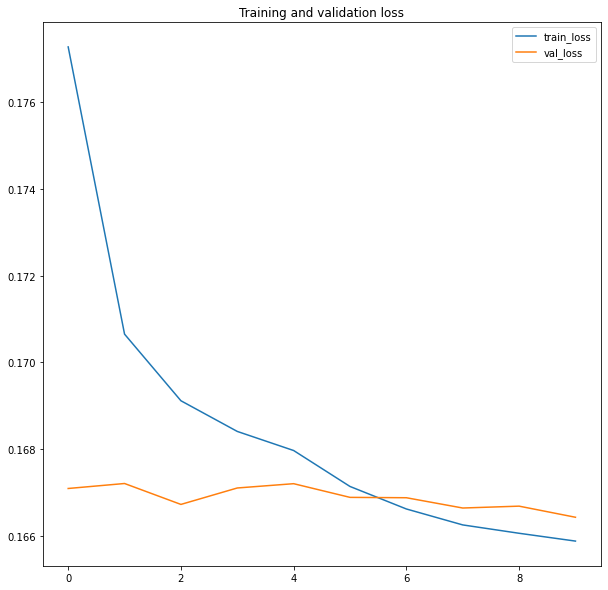

In [81]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.title('Training and validation loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

Resultados

In [82]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print(classification_report(labels_train, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44      7941
           1       0.50      0.62      0.55      7941

    accuracy                           0.50     15882
   macro avg       0.50      0.50      0.50     15882
weighted avg       0.50      0.50      0.50     15882



In [83]:
y_pred = np.round(model.predict(test_flow)).flatten()
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      8823
           1       0.80      1.00      0.89      8823

    accuracy                           0.87     17646
   macro avg       0.90      0.87      0.87     17646
weighted avg       0.90      0.87      0.87     17646



##### Handcrafted features

Aqui são extraídas features manualmente (Github do livro).

In [84]:
from community import community_louvain

def get_shortest_path(G,u,v):
    """ return the shortest path length between u,v 
        in the graph without the edge (u,v) """
    removed = False
    if G.has_edge(u,v):
      removed = True
      G.remove_edge(u,v) # temporary remove edge
    
    try:
      sp = len(nx.shortest_path(G, u, v))
    except:
      sp = 0

    if removed:
      G.add_edge(u,v) # add back the edge if it was removed

    return sp

def get_hc_features(G, samples_edges, labels):
    # precompute metrics
    centralities = nx.degree_centrality(G)
    #parts = community.best_partition(G)
    parts = community_louvain.best_partition(G)
    
    feats = []
    for (u,v),l in zip(samples_edges, labels):
      shortest_path = get_shortest_path(G, u, v)
      j_coefficient = next(nx.jaccard_coefficient(G, ebunch=[(u, v)]))[-1]
      u_centrality = centralities[u]
      v_centrality = centralities[v]
      # Coommunity ID assigned to node v using the Louvain heuristic
      u_community = parts.get(u)
      v_community = parts.get(v)
      # add the feature vector - 4 features
      feats += [[shortest_path, j_coefficient, u_centrality, v_centrality]]
    return feats

feat_train = get_hc_features(graph_train, samples_train, labels_train)
feat_test = get_hc_features(graph_test, samples_test, labels_test)

In [85]:
import pandas as pd
df = pd.DataFrame(feat_train, columns=['shortest_path', 'j_coefficient', 'u_centrality', 'v_centrality'])
df.head()

,shortest_path,j_coefficient,u_centrality,v_centrality
0,3,0.088889,0.017088,0.007182
1,3,0.305732,0.036404,0.014364
2,3,0.162162,0.006686,0.003962
3,3,0.281938,0.024269,0.047796
4,3,0.037383,0.022784,0.004705


Resultados

In [86]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

randf = RandomForestClassifier(n_estimators=10) 
randf.fit(feat_train, labels_train); 
 
y_pred = randf.predict(feat_test) 
print(classification_report(labels_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8823
           1       0.96      0.98      0.97      8823

    accuracy                           0.97     17646
   macro avg       0.97      0.97      0.97     17646
weighted avg       0.97      0.97      0.97     17646



In [87]:
# GridSearchCV por curiosidade, mas sem alterações significativas
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [5, 10, None]
}

grid = GridSearchCV(estimator=randf, param_grid=param_grid, cv=5)
grid.fit(feat_train, labels_train)
print(grid.best_params_)

{'max_depth': 10, 'n_estimators': 25}


In [88]:
randfc = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=101)
randfc.fit(feat_train, labels_train);
y_pred = randfc.predict(feat_test)
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8823
           1       0.96      0.98      0.97      8823

    accuracy                           0.97     17646
   macro avg       0.97      0.97      0.97     17646
weighted avg       0.97      0.97      0.97     17646



# Referências

* C. Stamile, A. Marzullo, E. Deusebio. Graph Machine Learning, 2021 + [Github do livro](https://github.com/PacktPublishing/Graph-Machine-Learning) (uso de código/funções e expansão da análise).

* Chami et al. [Machine Learning on Graphs: A Model and Comprehensive Taxonomy](https://arxiv.org/abs/2005.03675), 2022.